In [40]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"   

from xgboost import XGBClassifier


In [41]:
df = pd.read_csv("retentiondata_case (7).csv")

print(df.shape)
df.head()


(5636, 36)


,acct_ref,cust_ref,has_dependents,tenure_mo,home_phone,multi_line,internet_plan,add_on_security,add_on_backup,add_on_protection,...,recent_offer,avg_long_dist_fee,internet_tech,avg_gb_download,premium_support,stream_music,unlimited_data_opt,refunds_total,extra_data_fees_total,long_dist_fees_total
0,ACCT137932,CUST61880322,No,1,No,No phone service,DSL,No,Yes,No,...,Offer E,0.00,DSL,10,No,No,Yes,0.0,0,0.00
1,ACCT115088,CUST55192304,No,34,Yes,No,DSL,Yes,No,Yes,...,NaN,17.09,DSL,16,No,No,Yes,0.0,0,581.06
2,ACCT623423,CUST16890051,No,2,Yes,No,DSL,Yes,Yes,No,...,NaN,10.47,DSL,21,No,No,Yes,0.0,0,20.94
3,ACCT846960,CUST99388728,No,45,No,No phone service,DSL,Yes,No,Yes,...,NaN,0.00,DSL,10,Yes,No,Yes,0.0,0,0.00
4,ACCT146586,CUST91125265,No,2,Yes,No,Fiber optic,No,No,No,...,NaN,9.12,Fiber Optic,51,No,No,Yes,0.0,0,18.24


DATA CLEANING

In [42]:
def clean_base(df: pd.DataFrame):
    df = df.copy()

    # target
    y = (df["left_flag"].astype("string").str.strip().str.lower() == "yes").astype("int64")
    X = df.drop(columns=["left_flag"]).copy()

    # standardizing missing + trim strings
    X = X.replace({"NA": np.nan, "NaN": np.nan, "N/A": np.nan, "na": np.nan, "": np.nan})
    for c in X.select_dtypes(include=["object", "string"]).columns:
        X[c] = X[c].astype("string").str.strip()

    # dropping IDs
    X = X.drop(columns=[c for c in ["acct_ref", "cust_ref"] if c in X.columns], errors="ignore")

    # dropping zero-variance cols
    zero_var = [col for col in X.columns if X[col].nunique(dropna=False) <= 1]
    X = X.drop(columns=zero_var, errors="ignore")

    # refunds_total -> binary received_refund
    if "refunds_total" in X.columns:
        X["refunds_total"] = pd.to_numeric(X["refunds_total"], errors="coerce").fillna(0)
        X["received_refund"] = (X["refunds_total"] > 0).astype(int)
        X = X.drop(columns=["refunds_total"], errors="ignore")

    # standardizing service tokens
    service_like = [
        "multi_line", "add_on_security", "add_on_backup", "add_on_protection",
        "tech_support_std", "stream_tv", "stream_movies", "stream_music", "premium_support"
    ]
    for c in [c for c in service_like if c in X.columns]:
        X[c] = X[c].replace({"No internet service": "No", "No phone service": "No"})

    # home_phone -> 0/1 (safe)
    if "home_phone" in X.columns:
        X["home_phone"] = (
            X["home_phone"]
            .replace({"No phone service": "No"})
            .map({"Yes": 1, "No": 0})
            .fillna(0)
            .astype(int)
        )

    # converting key numeric columns if present
    num_cols = [
        "tenure_mo", "monthly_fee", "total_billed", "age_years",
        "dependents_count", "referrals_count", "avg_long_dist_fee",
        "avg_gb_download", "extra_data_fees_total", "long_dist_fees_total"
    ]
    for c in [c for c in num_cols if c in X.columns]:
        X[c] = pd.to_numeric(X[c], errors="coerce")

    return X, y

X_base, y = clean_base(df)
X_base.shape, y.mean()


((5636, 32), np.float64(0.2654364797728886))

FEATURE ENGINEERING

In [43]:
def engineer_features(X: pd.DataFrame):
    X = X.copy()

    # tenure featureS
    if "tenure_mo" in X.columns:
        X["tenure_mo"] = pd.to_numeric(X["tenure_mo"], errors="coerce")
        X["tenure_log1p"] = np.log1p(X["tenure_mo"].fillna(0))

        bins = [-np.inf, 6, 12, 24, 48, 72, np.inf]
        labels = ["0-6", "7-12", "13-24", "25-48", "49-72", "73+"]
        X["tenure_group"] = pd.cut(X["tenure_mo"], bins=bins, labels=labels)

    # bundle_score (count of Yes add-ons/streaming/support)
    service_cols = [
        "add_on_security", "add_on_backup", "add_on_protection",
        "tech_support_std", "premium_support",
        "stream_tv", "stream_movies", "stream_music"
    ]
    service_cols = [c for c in service_cols if c in X.columns]

    def to_binary_service(s):
        s = s.astype("string").replace({"No internet service": "No", "No phone service": "No"})
        return s.map({"Yes": 1, "No": 0}).fillna(0).astype(int)

    for c in service_cols:
        X[c] = to_binary_service(X[c])

    if service_cols:
        X["bundle_score"] = X[service_cols].sum(axis=1)
        # drop originals to reduce redundancy (recommended)
        X = X.drop(columns=service_cols, errors="ignore")
    else:
        X["bundle_score"] = 0

    # autopay flag from pay_method 
    if "pay_method" in X.columns:
        pm = X["pay_method"].astype("string").fillna("")
        X["is_autopay"] = pm.str.contains("automatic", case=False, na=False).astype(int)
    else:
        X["is_autopay"] = 0

    # penalties
    for c in ["extra_data_fees_total", "long_dist_fees_total"]:
        if c in X.columns:
            X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0)
        else:
            X[c] = 0

    X["penalty_fees_total"] = X["extra_data_fees_total"] + X["long_dist_fees_total"]

    # penalty rate (safe divide) 
    if "total_billed" in X.columns:
        denom = pd.to_numeric(X["total_billed"], errors="coerce").fillna(0).replace(0, 1)
        X["penalty_fee_rate"] = X["penalty_fees_total"] / denom

    # billing per month features
    if "total_billed" in X.columns and "monthly_fee" in X.columns and "tenure_mo" in X.columns:
        t = X["tenure_mo"].fillna(0).replace(0, 1)
        X["avg_billed_per_month"] = pd.to_numeric(X["total_billed"], errors="coerce").fillna(0) / t
        X["fee_minus_avg_billed"] = pd.to_numeric(X["monthly_fee"], errors="coerce").fillna(0) - X["avg_billed_per_month"]

    # Missing flag 
    if "recent_offer" in X.columns:
        X["recent_offer_missing"] = X["recent_offer"].isna().astype(int)
    else:
        X["recent_offer_missing"] = 0

    # Handling Missing Values
    # Categorical
    if "recent_offer" in X.columns:
        X["recent_offer"] = X["recent_offer"].fillna("Unknown")

    if "internet_tech" in X.columns:
        X["internet_tech"] = X["internet_tech"].fillna("Unknown")

    # Numeric
    if "total_billed" in X.columns:
        X["total_billed"] = X["total_billed"].fillna(X["total_billed"].median())

    return X




In [44]:
X_fe = engineer_features(X_base)
X_fe.shape

featured_with_target = X_fe.copy()
featured_with_target["left_flag"] = y.values
featured_with_target.to_csv("featured_dataset_with_target.csv", index=False)


In [45]:
#KMEANS: PREPARING DATA

X_cluster = X_fe.copy()

cat_cols_clust = X_cluster.select_dtypes(include=["object", "category", "string", "bool"]).columns.tolist()
num_cols_clust = [c for c in X_cluster.columns if c not in cat_cols_clust]

numeric_pipeline_clust = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline_clust = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_cluster = ColumnTransformer([
    ("num", numeric_pipeline_clust, num_cols_clust),
    ("cat", categorical_pipeline_clust, cat_cols_clust)
])

X_cluster_processed = preprocess_cluster.fit_transform(X_cluster)
if hasattr(X_cluster_processed, "toarray"):
    X_cluster_processed = X_cluster_processed.toarray()

print("Clustering matrix shape:", X_cluster_processed.shape)


Clustering matrix shape: (5636, 59)


In [46]:
# KMEANS: PRINCIPAL COMPONENT ANALYSIS (REDUCE DIMENSION)
from sklearn.decomposition import PCA

pca = PCA(n_components=0.90, random_state=42)  # keeping 90% variance
X_cluster_pca = pca.fit_transform(X_cluster_processed)

print("After PCA shape:", X_cluster_pca.shape)


After PCA shape: (5636, 19)


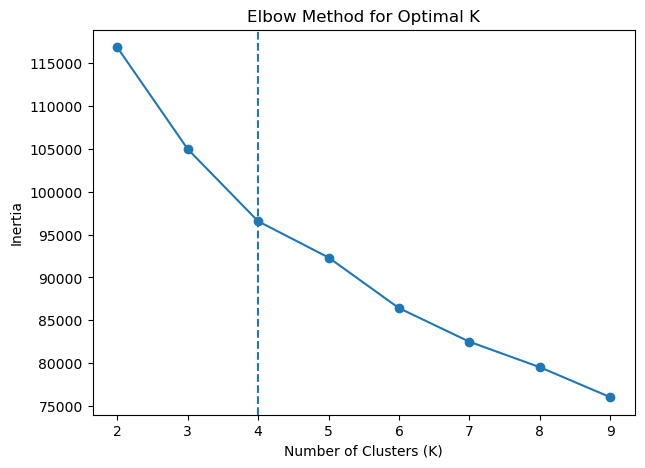

In [66]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# How tightly grouped are customers inside each segment?
inertia = []

K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_cluster_pca)
    inertia.append(km.inertia_)

plt.figure(figsize=(7,5))

plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")

plt.axvline(4, linestyle='--')  # highlight chosen K

plt.show()



In [67]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for k in range(2,8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_cluster_pca)
    score = silhouette_score(X_cluster_pca, labels)
    print(f"k={k}, silhouette={score}")


k=2, silhouette=0.17053999893250812
k=3, silhouette=0.1588654781689023
k=4, silhouette=0.17604816126865697
k=5, silhouette=0.13028648533261786
k=6, silhouette=0.14271891032953463
k=7, silhouette=0.12344483932168361


In [48]:
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_cluster_pca)

df["cluster"] = clusters


In [49]:
df["left_flag"].head(10) #checking target column

0     No
1     No
2    Yes
3     No
4    Yes
5     No
6     No
7    Yes
8     No
9     No
Name: left_flag, dtype: object

In [58]:
df["left_flag"] = (
    df["left_flag"]
    .astype(str)
    .str.strip()
    .str.upper()
    .map({"NO": 0, "YES": 1})
)
df["left_flag"].value_counts(dropna=False) #converting churn into numeric


left_flag
NaN    5636
Name: count, dtype: int64

In [59]:
# restore churn from y (0/1)
df["left_flag"] = y.values
df["left_flag"].value_counts(dropna=False)


left_flag
0    4140
1    1496
Name: count, dtype: int64

In [60]:
df.groupby("cluster")["left_flag"].mean().sort_values(ascending=False) #cluster evaluation

cluster
3    0.475371
1    0.251346
0    0.153584
2    0.074797
Name: left_flag, dtype: float64

In [61]:
df.groupby("cluster")[["tenure_mo","monthly_fee","total_billed"]].mean()


,tenure_mo,monthly_fee,total_billed
cluster,,,
0,56.207053,90.858049,5133.441951
1,31.315978,42.006284,1479.950541
2,30.721138,21.547561,683.042198
3,13.782401,74.363152,1054.687661


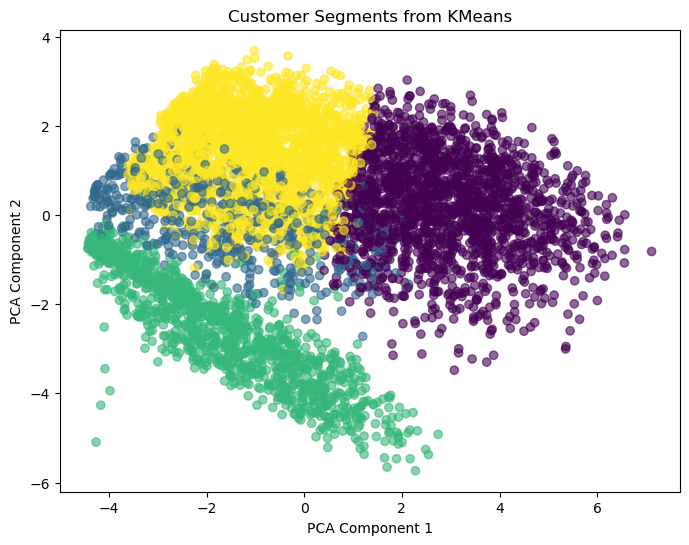

In [64]:
df["cluster"].value_counts(normalize=True) #Segment sizes

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    X_cluster_pca[:,0],
    X_cluster_pca[:,1],
    c=clusters,
    cmap='viridis',
    alpha=0.6
)

plt.title("Customer Segments from KMeans")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show() # Visualizing clusters


MODDELLING FOR XGBoost

In [71]:
df["cluster"] = clusters  #adds new column cluster
X_model = X_fe.copy()     #create duplicate of feature engeneered data
X_model["cluster"] = clusters # adding cluster label as predictor variable
X_model["cluster"] = X_model["cluster"].astype(str) # convering clusters to text/categories


TRAIN/ TEST SPLIT

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_model,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())



(4508, 34) (1128, 34)
0.265527950310559 0.2650709219858156


PREPROCESSING (impute + one-hot + scale)

In [74]:
cat_cols = X_train.select_dtypes(include=["object", "category", "string", "bool"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols)
    ],
    remainder="drop"
)

BUILDING + FITTING XGBoost PIPELINE

In [75]:
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

xgb_pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        min_child_weight=1,
        gamma=0,
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['tenure_mo', 'home_phone',
                                                   'monthly_fee',
                                                   'total_billed', 'age_years',
                                                   'dependents_count',
                                                   'referrals_count',
                                                   'avg_long_dist_fee',
                                                   'avg_gb_download',
                                                   'extra_data_fees_total',
                                                   'long_dist_fees_total',
                                                   'received_refund',
                                                   'tenure_log...
                               feature_types=None, feature_weights=None,
                               gamma=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=400, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [76]:
# EVALUATING MODEL
test_prob = xgb_pipeline.predict_proba(X_test)[:, 1]
test_pred = (test_prob >= 0.50).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, test_prob))
print("\nConfusion matrix:\n", confusion_matrix(y_test, test_pred))
print("\nClassification report:\n", classification_report(y_test, test_pred, digits=3))


ROC-AUC: 0.8999640942264324

Confusion matrix:
 [[695 134]
 [ 65 234]]

Classification report:
               precision    recall  f1-score   support

           0      0.914     0.838     0.875       829
           1      0.636     0.783     0.702       299

    accuracy                          0.824      1128
   macro avg      0.775     0.810     0.788      1128
weighted avg      0.841     0.824     0.829      1128



FEATURE IMPORTANCE

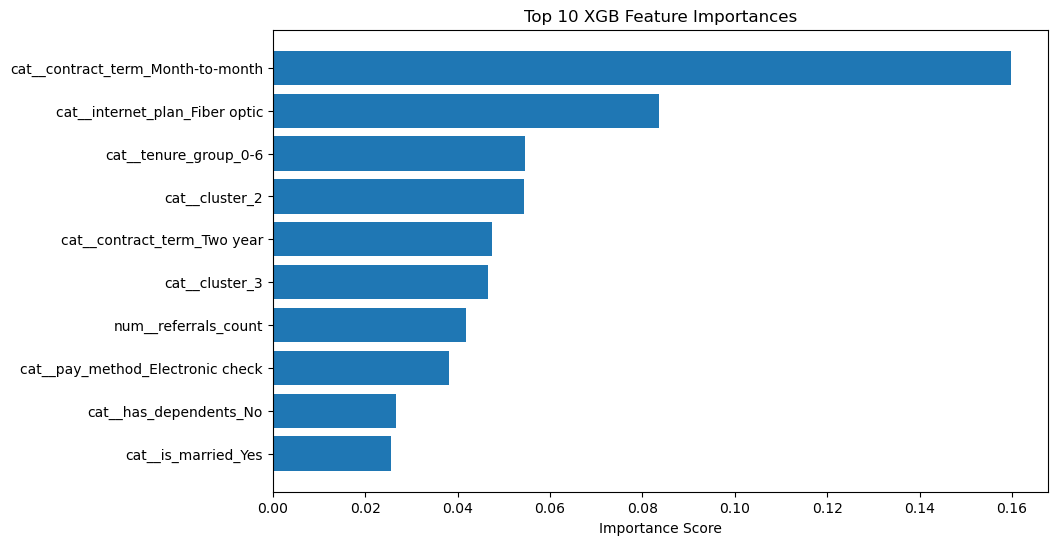

In [83]:
xgb_pipeline.fit(X_train, y_train)
xgb_model = xgb_pipeline.named_steps["model"]
preprocessor = xgb_pipeline.named_steps["preprocess"]
feature_names = preprocessor.get_feature_names_out()

import pandas as pd

importance = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb_model.feature_importances_
})

importance = importance.sort_values(by="importance", ascending=False)

import matplotlib.pyplot as plt

top_n = 10   # top 10

plt.figure(figsize=(10,6))

plt.barh(
    importance["feature"][:top_n][::-1], 
    importance["importance"][:top_n][::-1]
)

plt.xlabel("Importance Score")
plt.title("Top 10 XGB Feature Importances")

plt.show()



SHAP

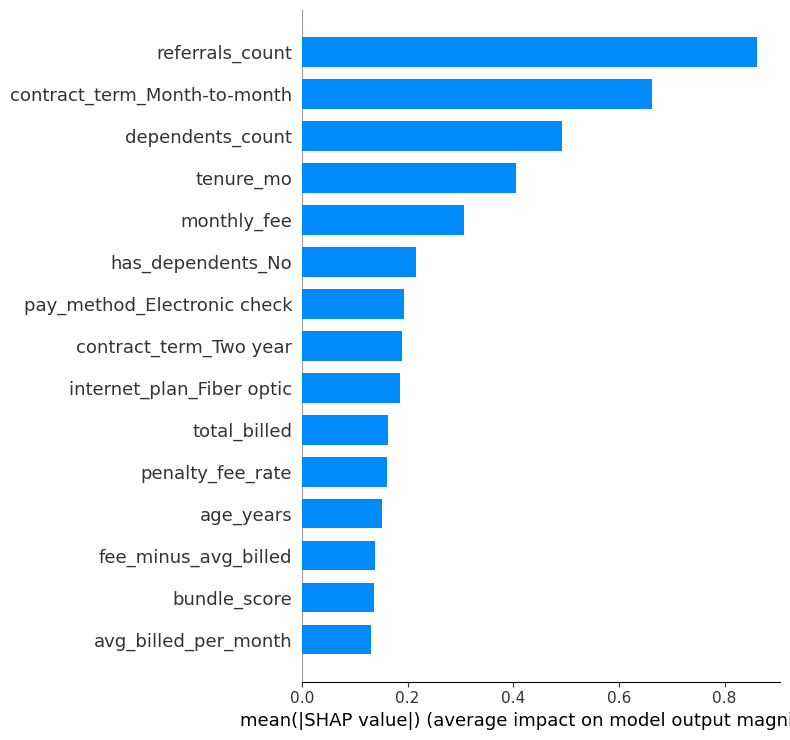

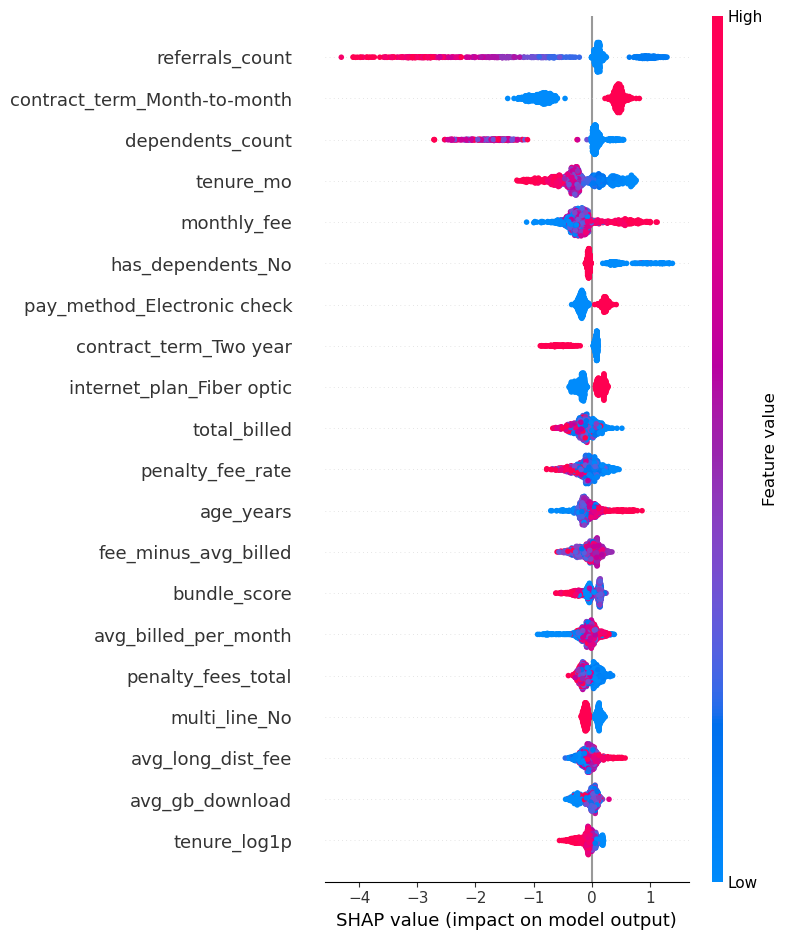

In [84]:
import shap

# pulling pieces from pipeline
preprocessor = xgb_pipeline.named_steps["preprocess"]
model = xgb_pipeline.named_steps["model"]

feature_names = preprocessor.get_feature_names_out()

X_test_transformed = preprocessor.transform(X_test)

# convert sparse
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# convert to dataframe
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# CLEANING FEATURE NAMES 
X_test_df.columns = X_test_df.columns.str.replace("num__", "", regex=False)
X_test_df.columns = X_test_df.columns.str.replace("cat__", "", regex=False)

# sampling for speed
X_shap = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# building explainer
explainer = shap.TreeExplainer(model)

# calculating shap values
shap_values = explainer.shap_values(X_shap)

# handling binary output
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# Bar Chart
shap.summary_plot(shap_values, X_shap, plot_type="bar", max_display=15)

# PLOT
shap.summary_plot(shap_values, X_shap, max_display=20)


In [85]:
import numpy as np
import pandas as pd

mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_importance = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)

shap_importance.head(10)


,feature,mean_abs_shap
6,referrals_count,0.861832
27,contract_term_Month-to-month,0.661957
5,dependents_count,0.493198
0,tenure_mo,0.406072
2,monthly_fee,0.307421
20,has_dependents_No,0.215117
34,pay_method_Electronic check,0.193101
29,contract_term_Two year,0.189482
25,internet_plan_Fiber optic,0.184957
3,total_billed,0.162991


In [86]:
shap_importance.to_csv("shap_feature_importance.csv", index=False)


In [87]:
import joblib

bundle = {
    "preprocess_cluster": preprocess_cluster,
    "pca": pca,
    "kmeans": kmeans,
    "xgb_pipeline": xgb_pipeline
}

joblib.dump(bundle, "group8_model_bundle.pkl")

print("Saved successfully!")


Saved successfully!
